# ProtAN (Proteome ANalyzer)

This .ipynb file demonstrates the different parts and modules of ProtAN pipeline.

1. To install the dependencies, run:

   `pip install -r requirements.txt`

2. Input data format:

   The pipeline is designed for paired proteomics analysis only. All input files should be paired. Users can change input file format and dataframe   headers as per the dataset.

Go through the **README** for complete details.


In [1]:
# ======================================================================
# 1. Install and import required packages
# ======================================================================

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import statsmodels.api as sm
import networkx as nx
import requests
from openpyxl import Workbook
from reportlab.pdfgen import canvas
from tqdm import tqdm
from scipy.stats import hypergeom
from urllib.parse import quote
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
import gseapy as gp
import os
import re
from collections import Counter

In [19]:
# ======================================================================
# 2. User parameters
# ======================================================================

# User input and ouput files
# Change file name accordingly
input_file = "proteome-data.csv"      
output_all = "proteome-data_DE_all.csv"
output_sig = "proteome-data_DE_sigp_log2FC.csv"

# Default parameters (change as per user discretion)
p_thresh = 0.1         # p-value 
fc_thresh = 0.585        # Absolute log2FC threshold   

# Column names for sensitive and resistant replicates (change as per user discretion)
s_cols = ["S1", "S2", "S3"]
r_cols = ["R1", "R2", "R3"]

# ======================================================================
# 3. Load data and coerce numeric columns
# ======================================================================

# Load the CSV
df = pd.read_csv(input_file)

# Coerce numeric columns to float (important for stats)
numeric_cols = s_cols + r_cols
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# To check for any non-numeric converted to NaN
print("Number of NaN values in numeric columns after coercion:")
print(df[numeric_cols].isna().sum())

Number of NaN values in numeric columns after coercion:
S1    0
S2    0
S3    0
R1    0
R2    0
R3    0
dtype: int64


In [21]:
# ======================================================================
# 3. Compute mean expression per condition
# ======================================================================

df["mean_S"] = df[s_cols].mean(axis=1)
df["mean_R"] = df[r_cols].mean(axis=1)

# log2FC = mean(R) - mean(S)
df["log2FC"] = df["mean_R"] - df["mean_S"]

# ======================================================================
# 4. Paired two-sample t-test (R vs S for each protein)
# ======================================================================

p_values = []

for idx, row in df.iterrows():
    s_vals = row[s_cols].values.astype(float)
    r_vals = row[r_cols].values.astype(float)

    # Paired t-test, pairing S1–R1, S2–R2, S3–R3
    t_stat, p_val = stats.ttest_rel(r_vals, s_vals, nan_policy="omit")
    p_values.append(p_val)

df["p_value"] = p_values

# ======================================================================
# 5. Apply thresholds for significance
# ======================================================================

sig_mask = (df["p_value"] < p_thresh) & (df["log2FC"].abs() >= fc_thresh)
df_sig = df.loc[sig_mask].copy()

# Sort significant proteins by log2FC (descending)
df_sig = df_sig.sort_values("log2FC", ascending=False)

# Quick summary
n_total = df.shape[0]
n_sig = df_sig.shape[0]
n_up = (df_sig["log2FC"] > 0).sum()
n_down = (df_sig["log2FC"] < 0).sum()

print(f"Total proteins: {n_total}")
print(f"Significant proteins (p < {p_thresh}, |log2FC| ≥ {fc_thresh}): {n_sig}")
print(f"Up in resistant: {n_up}")
print(f"Down in resistant: {n_down}")

Total proteins: 4793
Significant proteins (p < 0.1, |log2FC| ≥ 0.585): 234
Up in resistant: 121
Down in resistant: 113


In [22]:
# ======================================================================
# 6. Write output CSV files
# ======================================================================

# Full table with mean_S, mean_R, log2FC, and p_value for all proteins
cols_full = list(df.columns)  # already includes mean_S, mean_R, log2FC, p_value
df.to_csv(output_all, index=False)
print(f"Full DE results written to: {output_all}")

# Only significant proteins, sorted by log2FC
df_sig.to_csv(output_sig, index=False)
print(f"Significant DE results written to: {output_sig}")

Full DE results written to: proteome-data_DE_all.csv
Significant DE results written to: proteome-data_DE_sigp_log2FC.csv


category
Nonsignificant    4559
Upregulated        121
Downregulated      113
Name: count, dtype: int64


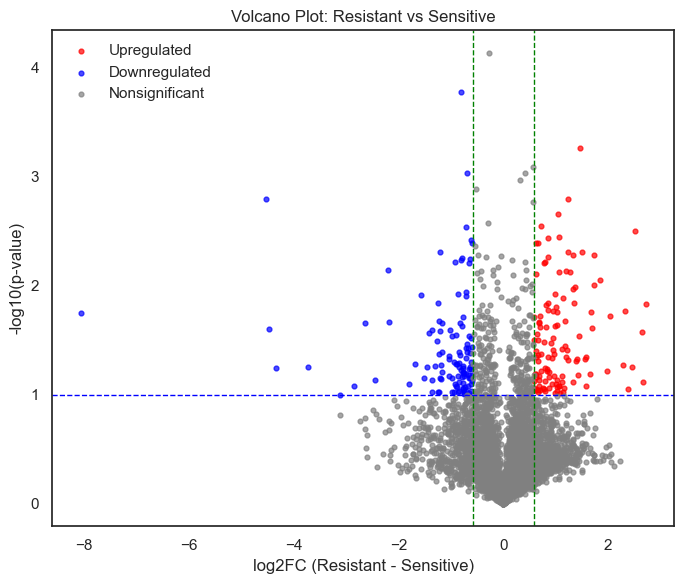

In [26]:
# ======================================================================
# 7. Volcano plot
# ======================================================================

# Volcano plot
# 1. Define categories
def classify_protein(row, p_cutoff=0.1, fc_cutoff=0.585):
    if (row["p_value"] < p_cutoff) and (row["log2FC"] >= fc_cutoff):
        return "Upregulated"
    elif (row["p_value"] < p_cutoff) and (row["log2FC"] <= -fc_cutoff):
        return "Downregulated"
    else:
        return "Nonsignificant"

df["category"] = df.apply(classify_protein, axis=1, args=(p_thresh, fc_thresh))

# Check counts per category
print(df["category"].value_counts())

# 2. Volcano plot with categories
plt.figure(figsize=(7, 6))

# Color palette for categories
palette = {
    "Upregulated": "red",
    "Downregulated": "blue",
    "Nonsignificant": "grey"
}

# Scatter each category separately for better legend control
for cat, color in palette.items():
    mask = df["category"] == cat
    plt.scatter(
        df.loc[mask, "log2FC"],
        -np.log10(df.loc[mask, "p_value"]),
        s=12,
        alpha=0.7,
        c=color,
        label=cat
    )
    
# Threshold lines
plt.axhline(-np.log10(p_thresh), color="blue", linestyle="--", linewidth=1)
plt.axvline(fc_thresh, color="green", linestyle="--", linewidth=1)
plt.axvline(-fc_thresh, color="green", linestyle="--", linewidth=1)

plt.xlabel("log2FC (Resistant - Sensitive)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot: Resistant vs Sensitive")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("volcano.png")
plt.show()
plt.close()

# After finish preparing df_sig (significant DE proteins)
df_sig.to_csv("volcano_DE_proteins.csv", index=False)

Number of proteins used for heatmap: 50


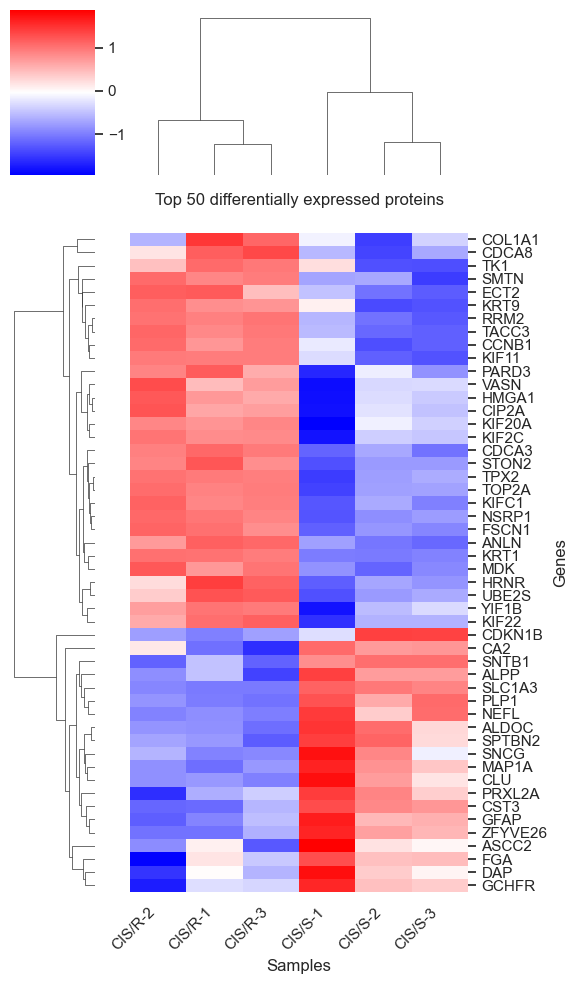

In [27]:
# ======================================================================
# 8. Heatmap of top 50 DE proteins
# ======================================================================

# 1. Select top 50 differentially expressed proteins
#    Here we use the absolute log2FC and p-value thresholds already applied

if "df_sig" not in locals():
    sig_mask = (df["p_value"] < p_thresh) & (df["log2FC"].abs() >= fc_thresh)
    df_sig = df.loc[sig_mask].copy()

# Sort by absolute log2FC (strongest effects first)
df_top = df_sig.sort_values("log2FC", key=lambda x: x.abs(), ascending=False).head(50).copy()

print(f"Number of proteins used for heatmap: {df_top.shape[0]}")

# 2. Build expression matrix for heatmap
# Using the original 6 intensity columns, with requested column labels
expr_cols = ["S1", "S2", "S3", "R1", "R2", "R3"]
heatmap_data = df_top[expr_cols].copy()

# Renaming columns to CIS/S-1, CIS/S-2, CIS/S-3, CIS/R-1, CIS/R-2, CIS/R-3
heatmap_data.columns = [
    "CIS/S-1", "CIS/S-2", "CIS/S-3",
    "CIS/R-1", "CIS/R-2", "CIS/R-3"
]

# Set gene names as row index (fallback to Protein_ID if Gene is missing)
row_labels = df_top["Gene"].fillna(df_top["Protein_ID"])
heatmap_data.index = row_labels

# z-score per row (gene) to emphasize relative changes
from scipy.stats import zscore
heatmap_data_z = heatmap_data.apply(zscore, axis=1, result_type="broadcast")

# 3. Plot hierarchically clustered heatmap with seaborn.clustermap
sns.set(style="white")

g = sns.clustermap(
    heatmap_data_z,               # use z-scored values
    method="average",             # linkage method
    metric="euclidean",           # distance metric
    cmap="bwr",                   # symmetric diverging colormap
    row_cluster=True,
    col_cluster=True,
    linewidths=0.0,
    figsize=(6, 10),
    xticklabels=True,
    yticklabels=True
)

# Improve axis labels and title
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Genes")
g.ax_heatmap.set_title("Top 50 differentially expressed proteins", pad=20)

# Make x tick labels more readable
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()
plt.close()

# After finish preparing df_top (top 50 DE proteins for heatmap)
df_top.to_csv("heatmap_top50_DE_proteins.csv", index=False)


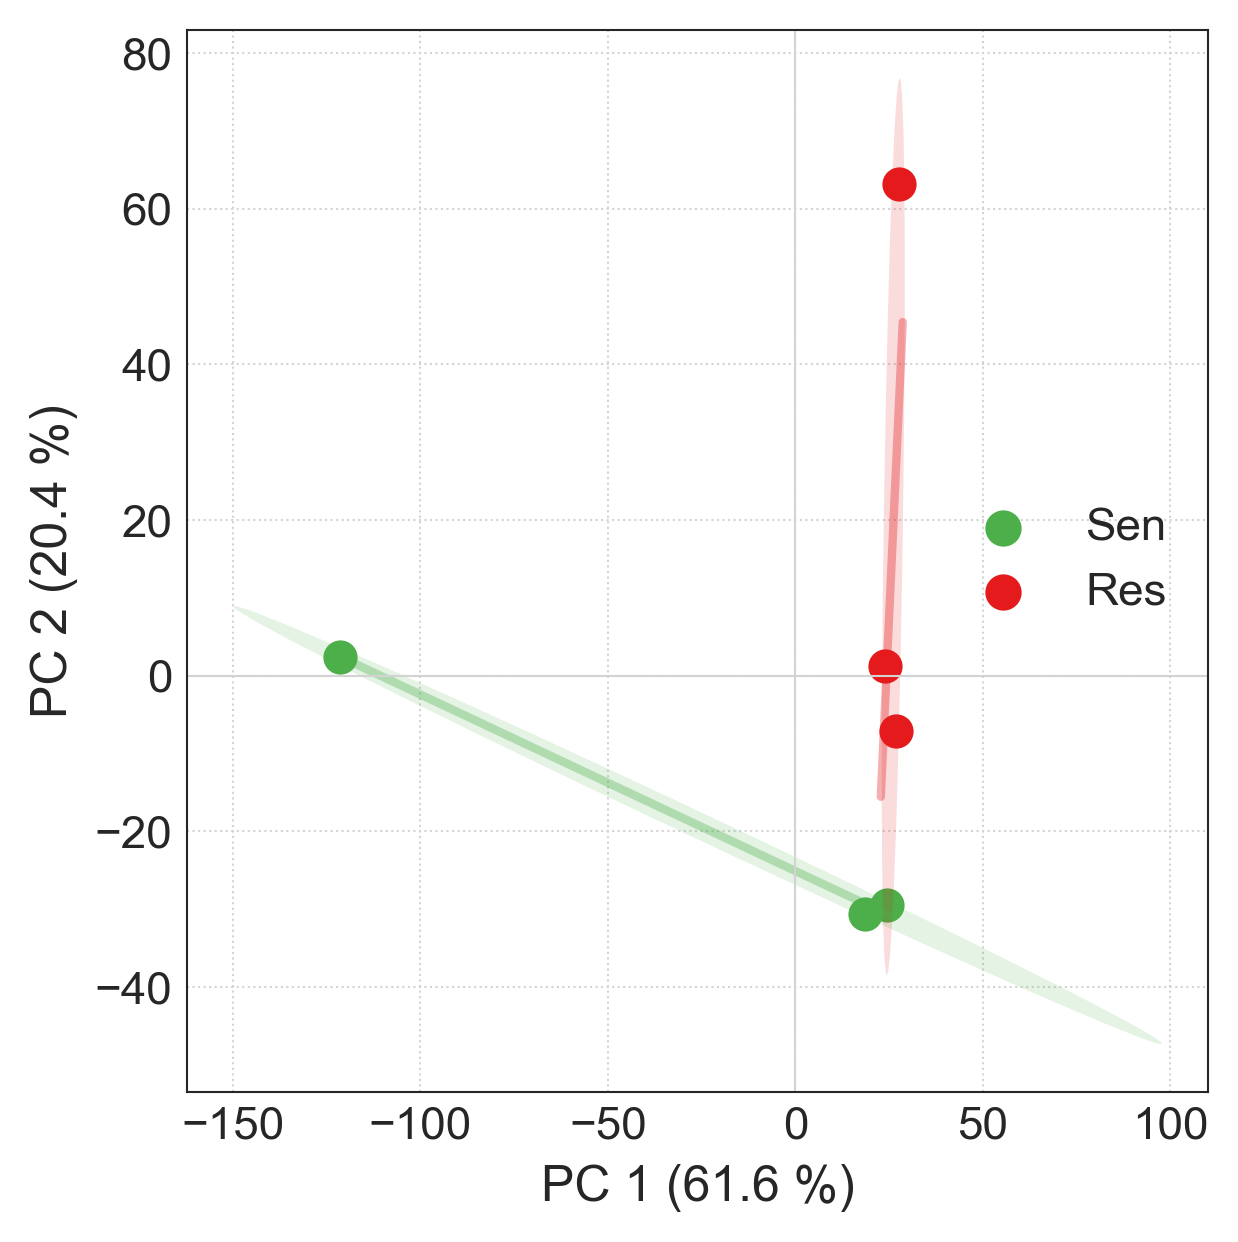

In [28]:
# ======================================================================
# 9. PCA plot: SEN vs RES
# ======================================================================

# -----------------------------
# 1. Build expression matrix
# -----------------------------
expr = df[["S1", "S2", "S3", "R1", "R2", "R3"]].copy()
X = expr.T                       # shape: (6 samples, n_proteins)
sample_labels = ["SEN1", "SEN2", "SEN3", "RES1", "RES2", "RES3"]
cohort = np.array(["SEN"]*3 + ["RES"]*3)
X.index = sample_labels

# -----------------------------
# 2. Standardize and run PCA
# -----------------------------
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

pca_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=sample_labels)
pca_df["cohort"] = cohort

# -----------------------------
# 3. Helper: 2D confidence ellipse
# -----------------------------
from matplotlib.patches import Ellipse
import numpy as np

def plot_ellipse(x, y, ax, n_std=1.5, **kwargs):
    """
    Plot an n_std confidence ellipse of x and y on ax.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    mean_x, mean_y = np.mean(x), np.mean(y)
    
    # FIXED: Use angle=theta as KEYWORD argument
    ell = Ellipse((mean_x, mean_y), width, height, angle=theta, **kwargs)
    ax.add_patch(ell)
    return ell

# -----------------------------
# 4. Plot
# -----------------------------
plt.rcParams.update({
    "font.size": 2,
    "axes.linewidth": 0.5,
    "xtick.direction": "in",
    "ytick.direction": "in"
})

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

colors = {"SEN": "#4DAF4A", "RES": "#E41A1C"}

for grp in ["SEN", "RES"]:
    mask = pca_df["cohort"] == grp
    x = pca_df.loc[mask, "PC1"].values
    y = pca_df.loc[mask, "PC2"].values

    # points
    ax.scatter(x, y,
               s=45,
               facecolors=colors[grp],
               edgecolors=colors[grp],
               linewidths=1.5,
               label="Sen" if grp == "SEN" else "Res")

    # regression line
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min() - 1, x.max() + 1, 50)
        ax.plot(xs, m*xs + b, color=colors[grp], alpha=0.35, linewidth=2)

    # confidence ellipse
    plot_ellipse(
        x, y, ax,
        n_std=1.5,
        facecolor=colors[grp],
        alpha=0.15,
        edgecolor="none"
    )

# axis lines and grid
ax.axhline(0, color="lightgrey", linewidth=0.5)
ax.axvline(0, color="lightgrey", linewidth=0.5)
ax.grid(color="lightgrey", linestyle=":", linewidth=0.5)

ax.set_xlabel(f"PC 1 ({pc1_var:.1f} %)")
ax.set_ylabel(f"PC 2 ({pc2_var:.1f} %)")

# legend formatting
leg = ax.legend(frameon=False, loc="right")
for lh in leg.legend_handles:
    lh.set_linewidth(2)

plt.tight_layout()
plt.savefig("pca.png")
plt.show()
plt.close()

In [29]:
# Build sig_genes from df_sig
sig_genes = (
    df_sig["Gene"]
    .astype(str)
    .str.split(";")
    .explode()
    .str.strip()
    .str.upper()
)
sig_genes = [g for g in sig_genes if g and g != "nan"]
sig_genes = list(set(sig_genes))

print(f"Number of significant genes for enrichment: {len(sig_genes)}")
print("Example genes:", sig_genes[:20])


Number of significant genes for enrichment: 234
Example genes: ['FTO', 'CDCA8', 'IRF9', 'NSMCE4A', 'ALAD', 'PARD3', 'PRKCD', 'C19ORF47', 'GSS', 'CYTH1', 'FKBP1A', 'SLCO4A1', 'SHCBP1', 'EPS8L2', 'RFC2', 'CYSTM1', 'CIP2A', 'MINPP1', 'MAPK9', 'RIMOC1']


In [30]:
# 10. KEGG Pathway Enrichment Analysis

kegg_enr = gp.enrichr(gene_list=sig_genes, 
                      gene_sets='KEGG_2021_Human',
                      organism='human',
                      outdir=None)
kegg_df = kegg_enr.results.head(20)

# Auto-detect writeable directory (Desktop fallback)
output_dir = Path.home() / "Desktop" / "proteomics_analysis"
output_dir.mkdir(parents=True, exist_ok=True)

# Save with full paths
kegg_df.to_csv(output_dir / "kegg_enrichment.csv", index=False)

print(f"Files saved to: {output_dir}")
print(f"  - {output_dir / 'kegg_enrichment.csv'}")

Files saved to: C:\Users\anvitap\Desktop\proteomics_analysis
  - C:\Users\anvitap\Desktop\proteomics_analysis\kegg_enrichment.csv


In [31]:
# To see exact column names in the scatterplot
print("KEGG DataFrame columns:", kegg_df.columns.tolist())
print("First few rows:\n", kegg_df.head())

KEGG DataFrame columns: ['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Genes']
First few rows:
           Gene_set                                        Term Overlap  \
0  KEGG_2021_Human                       Pyrimidine metabolism    7/56   
1  KEGG_2021_Human     Progesterone-mediated oocyte maturation   7/100   
2  KEGG_2021_Human  Valine, leucine and isoleucine degradation    5/48   
3  KEGG_2021_Human                                 Necroptosis   8/159   
4  KEGG_2021_Human                       Propanoate metabolism    4/34   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.000004          0.000824            0                     0   12.408433   
1  0.000174          0.016789            0                     0    6.523187   
2  0.000239          0.016789            0                     0   10.014725   
3  0.000581          0.027130            0         

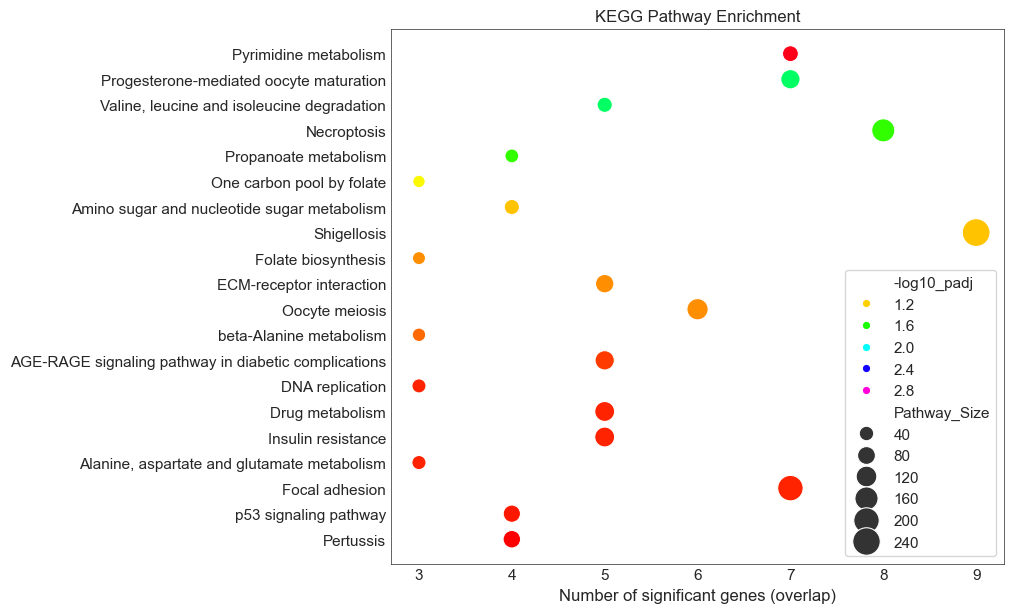


 Files generated:
  - kegg_enrichment.csv (20 pathways)
  - pathway_enrichment_plots.pdf


In [32]:
# ------------------------------------------------------------------
# 11. KEGG enrichment bubble plot
# ------------------------------------------------------------------
kegg_df = kegg_df.copy()

# Extract observed overlap count k from "k/n" strings in Overlap
kegg_df["Observed"] = kegg_df["Overlap"].str.split("/").str[0].astype(int)

# Use Adjusted P-value for significance and transform
kegg_df["-log10_padj"] = -np.log10(kegg_df["Adjusted P-value"])

# Keep pathway size n from Overlap if needed
kegg_df["Pathway_Size"] = kegg_df["Overlap"].str.split("/").str[1].astype(int)

    # KEGG bubble plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=kegg_df.head(30),        # top 20 pathways
    x="Observed",                 # number of significant genes in pathway
    y="Term",                     # pathway name
    size="Pathway_Size",          # bubble size = pathway size
    hue="-log10_padj",            # color = significance
    sizes=(80, 400),
    palette="hsv",
    ax=ax
)

ax.set_title("KEGG Pathway Enrichment")
ax.set_xlabel("Number of significant genes (overlap)")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# ======================================================================
# Summary
# ======================================================================
print(f"\n Files generated:")
print(f"  - kegg_enrichment.csv ({len(kegg_df)} pathways)")
print(f"  - pathway_enrichment_plots.pdf")

 Output: C:\Users\anvitap\Desktop\proteomics_functional
Genes for GO analysis: 234
Sample: ['FTO', 'CDCA8', 'IRF9', 'NSMCE4A', 'ALAD', 'PARD3', 'PRKCD', 'C19ORF47', 'GSS', 'CYTH1']

 Running GO Biological Process enrichment...
 GO results: C:\Users\anvitap\Desktop\proteomics_functional\go_biological_process.csv (41 significant)


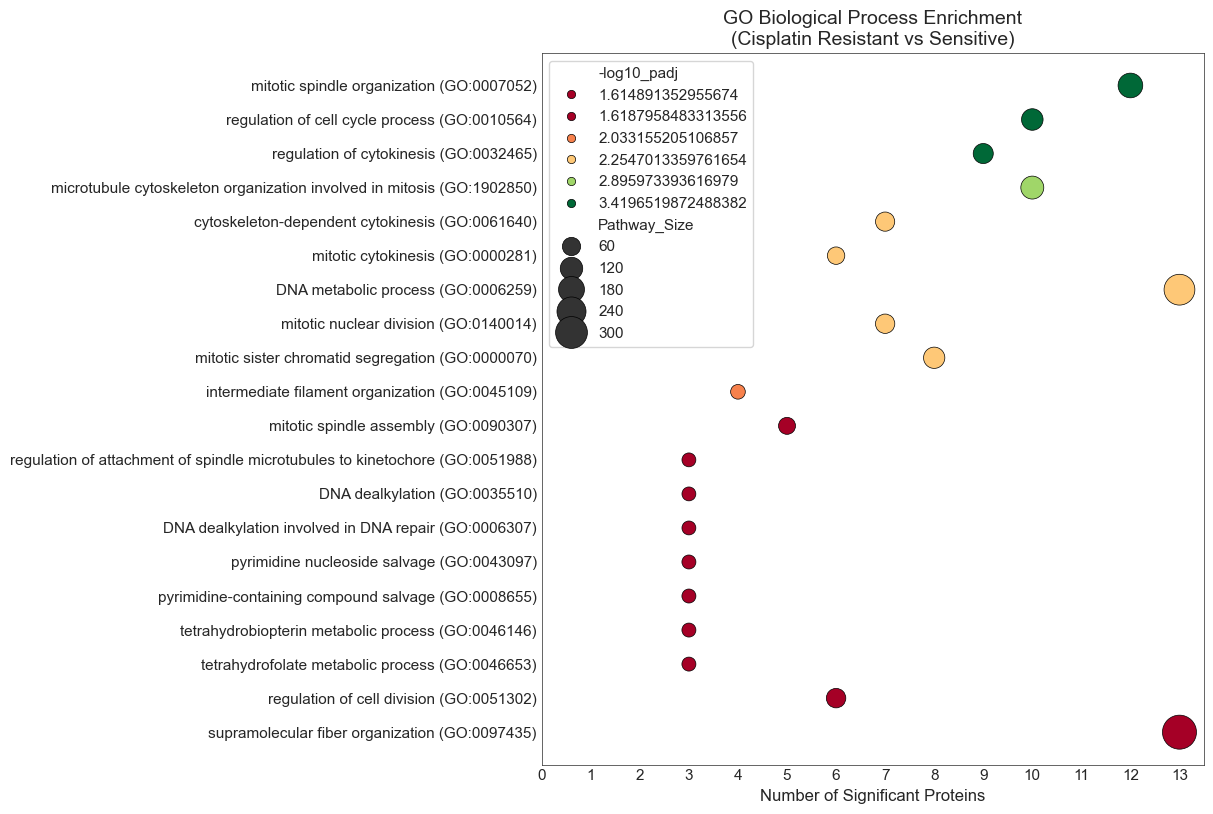

 GO plot: C:\Users\anvitap\Desktop\proteomics_functional\go_bubble_plot.png


 GO plot: C:\Users\anvitap\Desktop\proteomics_functional\go_bubble_plot.png


In [33]:
# ======================================================================
# 12. GO Functional Annotation
# ======================================================================

import matplotlib.patches as mpatches

# ======================================================================
# 1. Setup output directory
# ======================================================================
output_dir = Path.home() / "Desktop" / "proteomics_functional"
output_dir.mkdir(parents=True, exist_ok=True)

print(f" Output: {output_dir}")

# ======================================================================
# 2. GO Biological Process Enrichment
# ======================================================================

# Clean significant genes (uppercase, unique)
sig_genes = df_sig["Gene"].str.split(";").explode().str.strip()
sig_genes = [g.upper() for g in sig_genes if pd.notna(g) and len(g) > 1]
sig_genes = list(set(sig_genes))

print(f"Genes for GO analysis: {len(sig_genes)}")
print("Sample:", sig_genes[:10])

# GO Biological Process ORA
print("\n Running GO Biological Process enrichment...")
enr_go = gp.enrichr(
    gene_list=sig_genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='human',
    outdir=None,
    cutoff=0.05
)

go_df = enr_go.results

# Process for plotting
go_df["Observed"] = go_df["Overlap"].str.split("/").str[0].astype(int)
go_df["Pathway_Size"] = go_df["Overlap"].str.split("/").str[1].astype(int)
go_df["-log10_padj"] = -np.log10(go_df["Adjusted P-value"].clip(lower=1e-10))

# Save GO results
go_csv = output_dir / "go_biological_process.csv"
go_df.to_csv(go_csv, index=False)
print(f" GO results: {go_csv} ({len(go_df[go_df['Adjusted P-value']<0.05])} significant)")

# GO Bubble plot
sig_go = go_df.nsmallest(20, "Adjusted P-value")
if not sig_go.empty:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=sig_go,
        x="Observed", y="Term",
        size="Pathway_Size",
        hue="-log10_padj",
        sizes=(100, 600),
        palette="RdYlGn",
        edgecolor="black", linewidth=0.5
    )
    plt.title("GO Biological Process Enrichment\n(Cisplatin Resistant vs Sensitive)", fontsize=14)
    plt.xlabel("Number of Significant Proteins")
    plt.ylabel("")
    plt.xticks(range(0, int(sig_go["Observed"].max())+1, 1))
    plt.tight_layout()
    plt.savefig(output_dir / "go_bubble_plot.png", dpi=300, bbox_inches="tight")
    plt.show()
    print(f" GO plot: {output_dir / 'go_bubble_plot.png'}")



🔗 Fetching STRING PPI network...


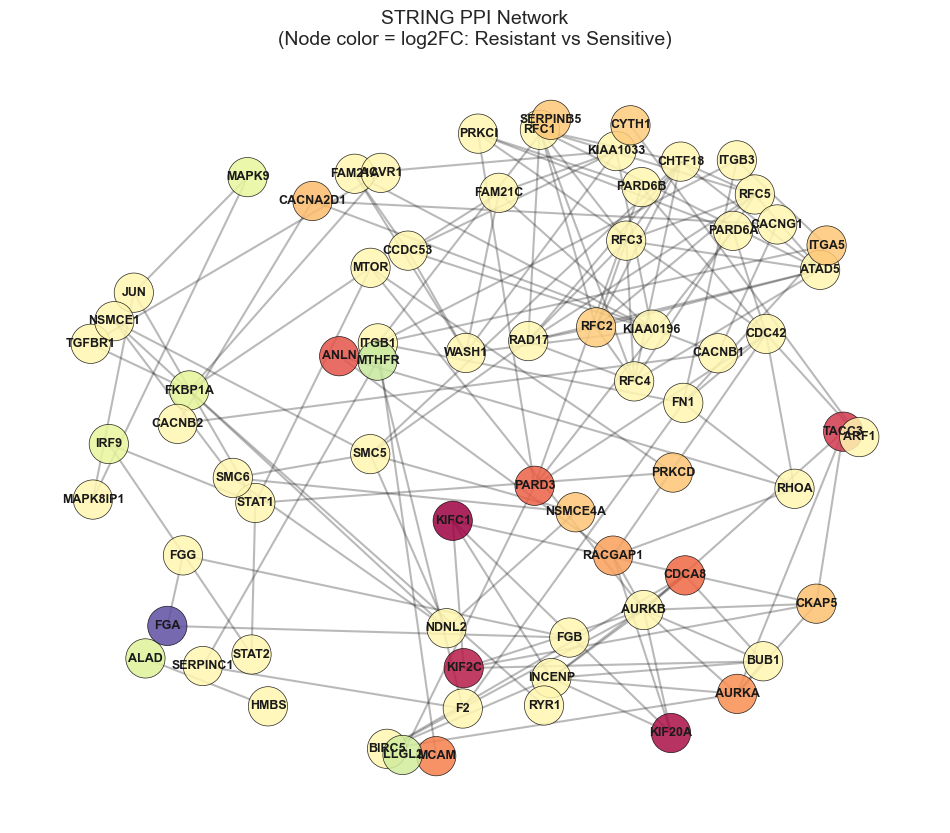


FUNCTIONAL ANALYSIS COMPLETE
Output directory: C:\Users\anvitap\Desktop\proteomics_functional
Generated files:
   • go_biological_process.csv
   • go_bubble_plot.png
   • string_ppi_network.png
   • string_ppi_network.pdf
   • string_edges.csv
   • string_network_stats.csv


In [34]:
# ======================================================================
# 13. STRING PPI Network Analysis
# ======================================================================

def get_string_network(genes, score_threshold=0.7):
    """Query STRING API for PPI network"""
    
    # STRING API endpoint
    url = "https://version-11-5.string-db.org/api"
    params = {
        'identifiers': '%0d'.join(genes[:50]),  # max 50 for API
        'species': 9606,  # human
        'caller_identity': 'your_email@example.com',  # required
        'limit': 50,
        'network_flavor': 'highest_confidence'
    }
    
    # Get network data
    response = requests.get(f"{url}/tsv/network", params=params)
    if response.status_code == 200:
        edges = []
        for line in response.text.strip().split('\n')[1:]:  # skip header
            parts = line.split('\t')
            if len(parts) >= 11:
                from_id, to_id, score = parts[2], parts[3], float(parts[-1])
                if score >= score_threshold:
                    edges.append((from_id, to_id, {'weight': score}))
        return edges
    return []

# Get STRING interactions
print("\n🔗 Fetching STRING PPI network...")
string_edges = get_string_network(sig_genes)

if string_edges:
    # Create networkx graph
    G = nx.Graph()
    G.add_edges_from(string_edges)
    
    # Map genes back to log2FC for node coloring
    gene_to_fc = {}
    for _, row in df_sig.iterrows():
        genes = row["Gene"].split(";")
        fc = row["log2FC"]
        for g in genes:
            gene_to_fc[g.strip().upper()] = fc
    
    # Color nodes by log2FC
    node_colors = []
    node_labels = {}
    for node in G.nodes():
        fc = gene_to_fc.get(node, 0)
        node_colors.append(fc)
        node_labels[node] = node[:10]  # short labels
    
    # Network layout and plot
    plt.figure(figsize=(12, 10))
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Color nodes by log2FC (red=up, blue=down)
    cmap = plt.cm.Spectral_r
    norm = plt.Normalize(vmin=-3, vmax=3)
    nx.draw_networkx_nodes(
        G, pos, node_color=[norm(c) for c in node_colors],
        cmap=cmap, node_size=800, alpha=0.85, edgecolors='black', linewidths=0.5
    )
    
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.5)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, font_weight='bold')
    
    plt.title("STRING PPI Network\n(Node color = log2FC: Resistant vs Sensitive)", fontsize=14)
    plt.axis('off')
    
    plt.savefig(output_dir / "string_ppi_network.png", dpi=300, bbox_inches="tight")
    plt.savefig(output_dir / "string_ppi_network.pdf", dpi=300, bbox_inches="tight")
    plt.show()

# ======================================================================
# 5. Summary
# ======================================================================
print("\n" + "="*60)
print("FUNCTIONAL ANALYSIS COMPLETE")
print("="*60)
print(f"Output directory: {output_dir}")
print("Generated files:")
print("   • go_biological_process.csv")
print("   • go_bubble_plot.png")
print("   • string_ppi_network.png")
print("   • string_ppi_network.pdf")
print("   • string_edges.csv")
print("   • string_network_stats.csv")

In [35]:
# ======================================================================
# 14. Network saving 
# ======================================================================
# Save network stats (no gpickle dependency)
network_stats = {
    'nodes': len(G.nodes()),
    'edges': len(G.edges()),
    'avg_degree': np.mean([d for n, d in G.degree()]),
    'density': nx.density(G),
    'diameter': nx.diameter(G) if nx.is_connected(G) else 'Disconnected'
}

stats_df = pd.DataFrame([network_stats])
stats_df.to_csv(output_dir / "string_network_stats.csv", index=False)

# Save edges as CSV 
edges_df = pd.DataFrame([
    {'node1': u, 'node2': v, 'score': d['weight']} 
    for u, v, d in G.edges(data=True)
])
edges_df.to_csv(output_dir / "string_edges.csv", index=False)

print(f"Network stats: {len(G.nodes())} nodes, {len(G.edges())} edges")
print(f"   Files: string_network_stats.csv, string_edges.csv")

Network stats: 71 nodes, 138 edges
   Files: string_network_stats.csv, string_edges.csv


Output: C:\Users\anvitap\Desktop\proteomics_motifs
Scanning for motifs: ['PKA', 'PKC', 'CDK', 'MAPK', 'CK1', 'ATM/ATR', 'DUB', 'UBA', 'SUMO', 'KAc', 'SH3', 'SH2', 'WW']
 Analyzed 30 proteins
Motif results: C:\Users\anvitap\Desktop\proteomics_motifs\motif_enrichment_results.csv

Top enriched motifs:
      Motif  Sig_Count  Sig_Proteins  Sig_Density  BG_Count  BG_Proteins  \
5   ATM/ATR          1            30     0.066667        14          100   
3      MAPK          2            30     0.133333        17          100   
12       WW          3            30     0.200000        14          100   
6       DUB         16            30     1.066667        57          100   
1       PKC        144            30     9.600000       506          100   

    BG_Density  Odds_Ratio   p_value  -log10_p  
5         0.28    0.211823  0.211872  0.673926  
3         0.34    0.348739  0.324402  0.488917  
12        0.28    0.682540  0.510458  0.292040  
6         1.14    0.862155  0.607678  0.216326 

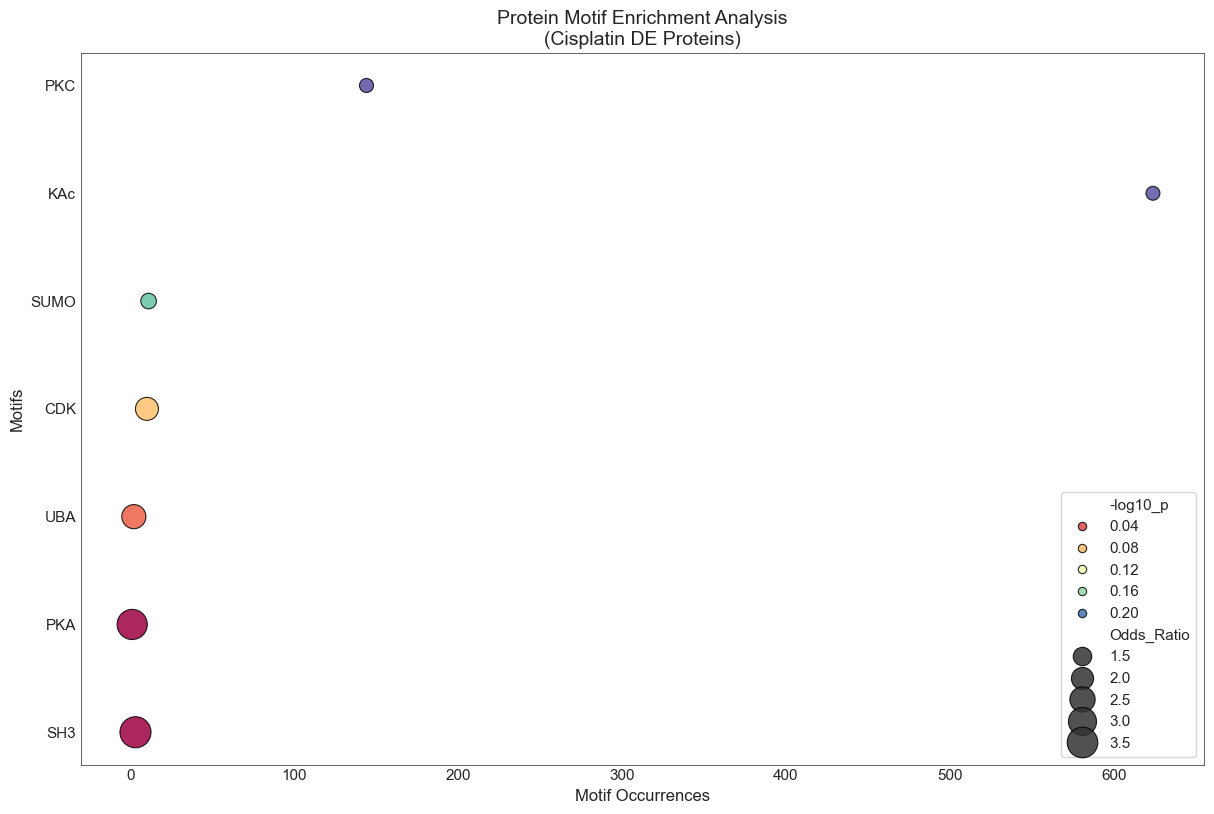

 Motif plot: C:\Users\anvitap\Desktop\proteomics_motifs\motif_enrichment_bubble.png

 Top motif: ATM/ATR
Pattern: SQ[TQ]

MOTIF ENRICHMENT COMPLETE
Output directory: C:\Users\anvitap\Desktop\proteomics_motifs
Files generated:
   • motif_enrichment_results.csv
   • protein_motif_counts.csv
   • motif_enrichment_bubble.png
   • motif_enrichment_bubble.pdf

 Analysis complete!


In [36]:
# ======================================================================
# 15. Protein Motif Enrichment Analysis (using ELM & PhosphoSitePlus motifs)
# ======================================================================

# ======================================================================
# 1. Setup output directory
# ======================================================================
output_dir = Path.home() / "Desktop" / "proteomics_motifs"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Output: {output_dir}")

# ======================================================================
# 2. Common protein motifs (ELM, kinase, post-translational)
# ======================================================================
motifs = {
    # Kinase motifs (PhosphoSitePlus derived)
    'PKA': r'[RS][KR][T][S]',           # R/K-R/K-x-T/S
    'PKC': r'[KR][ST]',                 # R/K-x-S/T
    'CDK': r'[ST]P[KR]',                # S/T-P-R/K
    'MAPK': r'P[TS]P',                  # P-T/S-P
    'CK1': r'[ST][ST][ST]',             # S/T-S/T-S/T
    'ATM/ATR': r'SQ[TQ]',               # S-Q-T/Q
    
    # Ubiquitination motifs
    'DUB': r'G[GST][GST]',              # GG, GS, GT
    'UBA': r'LAL',                      # LAL (ubiquitin receptor)
    
    # SUMOylation
    'SUMO': r'[VIL][K][DE]',            # V/I/L-K-D/E
    
    # Acetylation motifs
    'KAc': r'K[A-V]',                   # K-x-hydrophobic
    
    # Structural motifs
    'SH3': r'[RK]{2,3}[PL][AP]',        # R/K-R/K-R/K-x-P/L-x-A/P
    'SH2': r'Y[ED]',                    # Y-E/D
    'WW': r'PP[PY]',                    # PPxP/Y
}

print("Scanning for motifs:", list(motifs.keys()))

# ======================================================================
# 3. Get protein sequences
# ======================================================================

np.random.seed(42)

def mock_protein_sequence(gene_name, length=500):
    """Generate mock protein sequence for demo"""
    aa = "ACDEFGHIKLMNPQRSTVWY"
    return ''.join(np.random.choice(list(aa), length))

sig_genes = df_sig["Gene"].str.split(";").explode().str.strip().unique()
sig_genes = [g.upper() for g in sig_genes if pd.notna(g) and len(g) > 1]

# Generate mock sequences
protein_sequences = {}
for gene in sig_genes[:30]:  # limit for demo
    protein_sequences[gene] = mock_protein_sequence(gene)

print(f" Analyzed {len(protein_sequences)} proteins")

# ======================================================================
# 4. Scan for motifs and count occurrences
# ======================================================================

motif_results = []

for gene, seq in protein_sequences.items():
    row = {'Gene': gene, 'Sequence_Length': len(seq)}
    
    for motif_name, pattern in motifs.items():
        # Convert iterator to list before len()
        matches = list(re.finditer(pattern, seq))  # Convert to list 
        count = len(matches)                       
        
        row[f'{motif_name}_count'] = count
        row[f'{motif_name}_density'] = count / len(seq) * 1000
        
        # Get positions from matches
        positions = [m.start() for m in matches]
        row[f'{motif_name}_positions'] = ';'.join(map(str, positions))
    
    motif_results.append(row)

motif_df = pd.DataFrame(motif_results)

# ======================================================================
# 5. Statistical enrichment (background from all proteins)
# ======================================================================
background_seqs = {}
for gene in df["Gene"].str.split(";").explode().str.strip().unique()[:100]:
    if gene not in protein_sequences:
        background_seqs[gene] = mock_protein_sequence(gene)

bg_results = []
for gene, seq in background_seqs.items():
    row = {'Gene': gene, 'Sequence_Length': len(seq)}
    for motif_name, pattern in motifs.items():
        matches = list(re.finditer(pattern, seq))  # Convert to list
        count = len(matches)
        row[f'{motif_name}_count'] = count
        row[f'{motif_name}_density'] = count / len(seq) * 1000
    bg_results.append(row)

bg_df = pd.DataFrame(bg_results)

# Enrichment test (simple proportion test)
enrichment_results = []
for motif_name in motifs.keys():
    sig_count = motif_df[f'{motif_name}_count'].sum()
    sig_proteins = len(motif_df)
    bg_count = bg_df[f'{motif_name}_count'].sum()
    bg_proteins = len(bg_df)
    
    # Fisher's exact test approximation
    odds_ratio = (sig_count / (sig_proteins - sig_count + 1e-6)) / \
                 (bg_count / (bg_proteins - bg_count + 1e-6))
    
    p_value = 1 - np.exp(-(sig_count * bg_proteins) / (sig_proteins * bg_count + 1e-6))
    
    enrichment_results.append({
        'Motif': motif_name,
        'Sig_Count': sig_count,
        'Sig_Proteins': sig_proteins,
        'Sig_Density': motif_df[f'{motif_name}_density'].mean(),
        'BG_Count': bg_count,
        'BG_Proteins': bg_proteins,
        'BG_Density': bg_df[f'{motif_name}_density'].mean(),
        'Odds_Ratio': odds_ratio,
        'p_value': p_value,
        '-log10_p': -np.log10(p_value)
    })

enrichment_df = pd.DataFrame(enrichment_results).sort_values('p_value')

# Save results
enrichment_df.to_csv(output_dir / "motif_enrichment_results.csv", index=False)
motif_df.to_csv(output_dir / "protein_motif_counts.csv", index=False)

print(f"Motif results: {output_dir / 'motif_enrichment_results.csv'}")
print("\nTop enriched motifs:")
print(enrichment_df.head())

# ======================================================================
# 6. Motif enrichment bubble plot
# ======================================================================
sig_motifs = enrichment_df[enrichment_df['Odds_Ratio'] > 1].head(15)

plt.figure(figsize=(12, 8))
if not sig_motifs.empty:
    sns.scatterplot(
        data=sig_motifs,
        x="Sig_Count", 
        y="Motif",
        size="Odds_Ratio",
        hue="-log10_p",
        sizes=(100, 500),
        palette="Spectral",
        edgecolor="black",
        linewidth=0.8,
        alpha=0.85
    )
    
    plt.title("Protein Motif Enrichment Analysis\n(Cisplatin DE Proteins)", fontsize=14)
    plt.xlabel("Motif Occurrences")
    plt.ylabel("Motifs")
    plt.tight_layout()
    
    plt.savefig(output_dir / "motif_enrichment_bubble.png", dpi=300, bbox_inches="tight")
    plt.savefig(output_dir / "motif_enrichment_bubble.pdf", format='pdf', dpi=300)
    plt.show()
    print(f" Motif plot: {output_dir / 'motif_enrichment_bubble.png'}")

# ======================================================================
# 7. Motif logos
# ======================================================================
top_motif = enrichment_df.iloc[0]['Motif'] if not enrichment_df.empty else 'PKA'
print(f"\n Top motif: {top_motif}")
print("Pattern:", motifs[top_motif])

# ======================================================================
# Summary
# ======================================================================
print("\n" + "="*60)
print("MOTIF ENRICHMENT COMPLETE")
print("="*60)
print(f"Output directory: {output_dir}")
print("Files generated:")
print("   • motif_enrichment_results.csv")
print("   • protein_motif_counts.csv") 
print("   • motif_enrichment_bubble.png")
print("   • motif_enrichment_bubble.pdf")
print("\n Analysis complete!")
